# Introduction

In this project, we are trying to predict future taxi demand in NYC using past data. The NYC *Taxi & Limousine Commission* collects trip record data in NYC, so we use their publicly available data. For trip record data, guides, and other details, see [TLC Trip Record Data](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

This repo contains a module that creates and processes the data with a few commands. Here, we generate some data while highlighting what we can do with the module. Currently, the module only supports `yellow` taxi data. Implementing other taxis is can be implemented similarly.

## Load Packages

We process our data using `numpy` and `pandas`. We use `geopandas` for visualizing geographical data.

In [1]:
# for automatic reloading of modules (quick debugging)
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('..') # add parent directory to path

import numpy as np 
import pandas as pd
from utils import processing as pr
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

## Raw Taxi Data

The taxi data is stored in `parquet` files that contain event-level data for a given month. As an example, we load the `yellow` taxi data corresponding to Jan 2023 data and show its corresponding features. For more details see [Yellow Taxi Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf).

In [2]:
# load yellow taxi data for month 01/2023
df_y = pr.load_taxi_data(month = 1, year = 2023, vehicle_type = 'yellow')
df_y
# df_y[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PULocationID', 'DOLocationID', 'total_amount', 'tip_amount']].head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,None,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,None,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,None,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,None,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN


### Summary
The data contains the spatio-temporal information:
* `tpep_pickup_datetime` - Date & time of pickup
* `tpep_dropoff_datetime` - Date & time of dropoff
* `PULocationID` - Taxi Zone of pickup location
* `DOLocationID` - Taxi Zone of dropoff location

The spatial information does give the exact location of pickup or dropoff. It only provides the taxi zone corresponding to pickup and dropoff. The available taxi zones are areas of NYC and its neighboring areas. We show them in the cell below.

The data contains additional features such as fare pricing, tips, distance of trip, etc.

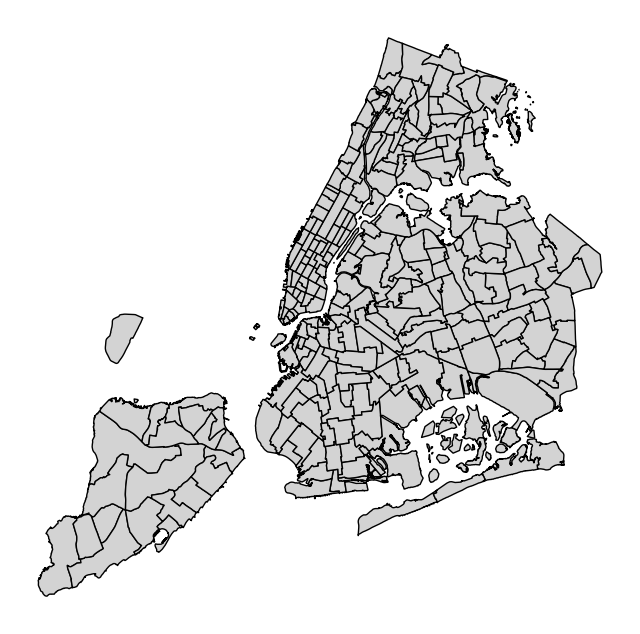

In [3]:
# Display Taxi Zones
gdf = gpd.read_file('../assets/tableau/taxi_zones/taxi_zones.shp')  # read shapefile
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(ax=ax, color='lightgrey', edgecolor='black')

# remove xticks and yticks
plt.xticks([])
plt.yticks([])
# remove square frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

fig.savefig('data/taxi_zones.png', transparent=True)

### Processing

This event-level taxi data is dense (just one month contains over 3,000,000 rows). We process this data to remove outliers and rides with missing information. The removal of outliers is indicated by the following conditions listed in `processing.load_and_process_data`:
```
    # impose conditions based on features
    df = df.dropna() # drop missing values (as per 01_b_cleaning_data.ipynb)
    conditions = (
        (df.pickup_datetime.dt.month == month) & (df.pickup_datetime.dt.year == year) & # filter by month and year
        (df.trip_distance > 0.) & (df.trip_distance < 500.) & # filter by trip distance
        (df.total_amount > 0.) & (df.total_amount < 5000.) & # filter by total amount
        (df.fare_amount > 0.) & (df.fare_amount < 5000.) & # filter by fare amount
        (df.tip_amount >= 0.) & (df.tip_amount < 1000.) &  # filter by tip amount 
        (df.trip_duration > 0.) & (df.trip_duration < 600.) & # filter by trip duration
        (df.passenger_count > 0.) & (df.passenger_count < 10) # filter by passenger count
        )
    df = df[conditions] # apply conditions
```
After that, we compress the data into hourly time series of taxi rides per pickup location. This introduces a new feature: the number of taxi rides starting from given pickup location per hour. This is done using the `processing.bin_data` function. 

In addition to the counts, we retain the following features in the raw data by taking the average of each of the following quantities per hour:
```
    if additional_features: # include additional features
        ts = (ts
            .join(gb.agg({'total_amount': 'mean'}))
            .join(gb.agg({'tip_amount': 'mean'}))
            .join(gb.agg({'fare_amount': 'mean'}))
            .join(gb.agg({'trip_distance': 'mean'}))
            .join(gb.agg({'passenger_count': 'mean'}))
            .join(gb.agg({'trip_duration': 'mean'}))
        )
```

For more details of processing, see the `02` series of notebooks in the `data_processing` directory.

## Load and Process Inland Manhattan Taxi Zone Data

We now load the dataset. It is handled month-by-month by the `load_and_process_data` function. The `generate_processed_data` handles a specified range of months and years.

We restrict ourselves to Manhattan taxi zones that are inland and not separated by a body of water.

In [4]:
# preprocess months and years to an (N,2)-array
months = np.arange(1,3+1,1)
years = np.arange(2023,2023+1,1)
month_year = np.meshgrid(years, months)
month_year = np.array(month_year).T.reshape(-1,2)

# indicate desired taxi zones
zdf = pd.read_csv('../assets/taxi_zone_lookup.csv')
zdf = zdf[(zdf['Borough'] == 'Manhattan') & (~zdf['LocationID'].isin([103, 104, 105, 153, 194, 202]))]
taxi_zones = list(zdf['LocationID'].values)

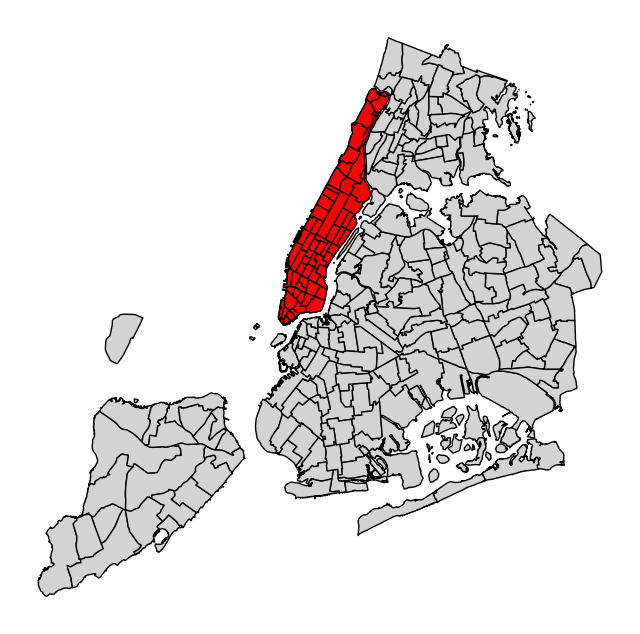

In [5]:
# Display Taxi Zones
gdf = gpd.read_file('../assets/tableau/taxi_zones/taxi_zones.shp')  # read shapefile
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf[(gdf['borough'] == 'Manhattan') & (~gdf['LocationID'].isin([103, 104, 105, 153, 194, 202]))].plot(ax=ax, color='red', edgecolor='black')

# remove xticks and yticks
plt.xticks([])
plt.yticks([])
# remove square frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

fig.savefig('data/taxi_zones.png', transparent=True)

In [6]:
# generate time series data
ts = pr.generate_processed_data(month_year, vehicle_type='yellow', by_value=['PULocationID'], additional_features=True, taxi_zones=taxi_zones)
ts

100%|██████████| 3/3 [00:14<00:00,  4.71s/it]


,PULocationID,pickup_datetime,counts,total_amount,tip_amount,fare_amount,trip_distance,passenger_count,trip_duration
0,4,2023-01-01 00:00:00-05:00,12,25.775000,3.716666,17.058332,2.837500,1.583333,14.916667
1,12,2023-01-01 00:00:00-05:00,1,20.520000,3.420000,12.100000,1.900000,1.000000,10.550000
2,13,2023-01-01 00:00:00-05:00,13,25.891539,3.460769,17.430769,3.242307,1.384615,12.601282
3,24,2023-01-01 00:00:00-05:00,15,21.676001,2.880666,14.941999,2.704000,1.333333,11.192222
4,41,2023-01-01 00:00:00-05:00,16,16.241875,2.216875,10.743750,1.514375,1.375000,9.560416
...,...,...,...,...,...,...,...,...,...
136012,246,2023-03-31 23:00:00-04:00,58,24.246895,3.200345,16.046553,2.729138,1.448276,13.606322
136013,249,2023-03-31 23:00:00-04:00,347,22.284611,3.007089,14.284725,2.096571,1.484150,13.661240
136014,261,2023-03-31 23:00:00-04:00,19,33.783157,4.635789,24.147367,4.421579,1.526316,20.358770
136015,262,2023-03-31 23:00:00-04:00,25,26.451601,4.311600,17.139999,3.199600,1.680000,13.640000


### Flexibility of Data Generator

We are not restricted to creating time series corresponding to rides starting to pickup location. We create time series corresponding to rides ending at a dropoff location or corresponding to routes starting at a pickup location and ending at a dropoff location. This is controlled by the `by_value` argument in `generate_and_processed_data` and its nested functions.

We show an example of the route-level data by setting `by_value = ['PULocationID', 'DOLocationID']`. For more details on working with route-level data, see the `02` and `03` series of notebooks in `data_processing`.

In [7]:
# generate time series data
ts_r = pr.generate_processed_data(month_year, vehicle_type='yellow', by_value=['PULocationID', 'DOLocationID'], additional_features=True, taxi_zones=taxi_zones)
ts_r

100%|██████████| 3/3 [00:22<00:00,  7.61s/it]


,pickup_datetime,DOLocationID,PULocationID,counts,total_amount,tip_amount,fare_amount,trip_distance,passenger_count,trip_duration
0,2023-01-01 00:00:00-05:00,4,4,0,0.00,0.00,0.00,0.000,0.0,0.000000
1,2023-01-01 00:00:00-05:00,12,4,0,0.00,0.00,0.00,0.000,0.0,0.000000
2,2023-01-01 00:00:00-05:00,13,4,0,0.00,0.00,0.00,0.000,0.0,0.000000
3,2023-01-01 00:00:00-05:00,24,4,0,0.00,0.00,0.00,0.000,0.0,0.000000
4,2023-01-01 00:00:00-05:00,41,4,0,0.00,0.00,0.00,0.000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
8026904,2023-03-31 23:00:00-04:00,246,263,0,0.00,0.00,0.00,0.000,0.0,0.000000
8026905,2023-03-31 23:00:00-04:00,249,263,2,46.32,8.57,32.75,5.940,1.5,30.741665
8026906,2023-03-31 23:00:00-04:00,261,263,0,0.00,0.00,0.00,0.000,0.0,0.000000
8026907,2023-03-31 23:00:00-04:00,262,263,1,13.10,3.00,5.10,0.500,1.0,3.583333


## Postprocessing
Our data requires some postprocessing. First, it may happen that a taxi zone (or route) has zero no rides at a given hour. The various features (e.g., `fare_amount`) in the dataset are undefined in this case. To each missing value of a quantity in a given taxi zone (or route), we assign to it a weighted average of the quantity over all the hours in the dataset in the taxi zone (or route). The quantities are weighted by the number of counts each hour.

Another subtle issue is there being a rate hike occurring at `Dec 19, 2022`. This introduces a jump in the price-level data. We remove the jump by scaling up the prices before the rate hike was applied by the appropriate amount (23%). 

We wrote the `postprocess_data` function so that it can be applied for either location-level or route-level time series data. For more details, see its documentation or the `03_a_further_processing.ipynb` notebook.

In [8]:
ts_p = pr.postprocess_data(ts, by_value=['PULocationID'])

### Save Taxi Dataframe and Geopandas Dataframe

This is the dataset we use to train various models. It is saved outside the repo. We also save a dataset of the specific taxi zones that we are using for future convenience.

In [57]:
os.system('mkdir -p ../../processed_taxi_data')

# save processed taxi dataframe
ts_p.to_pickle('../../processed_taxi_data/adjusted_yellow_2023-01_2023-03_bypulocation.pkl')

In [9]:
# Geopandas dataframe
gdf = gpd.read_file('../assets/tableau/taxi_zones/taxi_zones.shp')  # read shapefile
gdf = gdf[(gdf['borough'] == 'Manhattan') & (~gdf['LocationID'].isin([103, 104, 105, 153, 194, 202]))]

# extract coordinates of zones: https://gis.stackexchange.com/questions/412817/how-to-get-lat-and-lon-from-a-geopandas-geodataframe-polygon
gdf = gdf.to_crs(4326) # reproject data
gdf['lon'] = gdf.centroid.x  
gdf['lat'] = gdf.centroid.y
gdf.reset_index(drop=True, inplace=True)

# save geopandas dataframe
gdf.to_pickle('../../processed_taxi_data/manhattan_taxi_zones.pkl')

/tmp/ipykernel_580/3470049900.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/tmp/ipykernel_580/3470049900.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


## Sample Data Visualization

We consider East Village for some basic data visualization. 

For a simple Tableau App displaying the count data per taxi zone, see this [Link](https://public.tableau.com/app/profile/edward.ramirez/viz/taxi_map_with_taxi_zones/Dashboard?publish=yes). For the development of this, see `data_processing/99_tableau_processing.ipynb`.

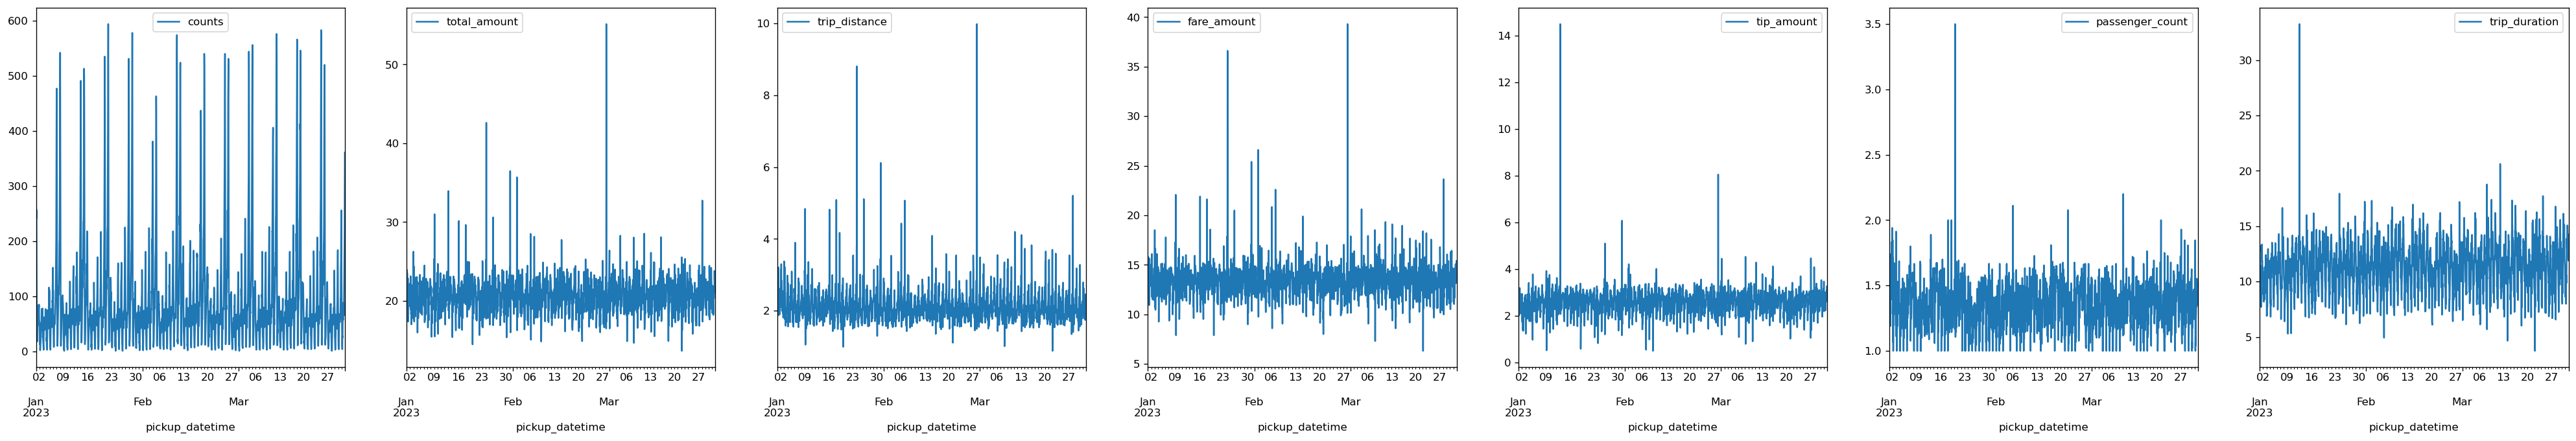

In [10]:
# time series data for zone 79
ts_z = ts_p[ts_p['PULocationID'] == 79].copy() # equivalent for route-level data: ts_z = pr.route_to_pulocation(ts, 4)
fig, axes = plt.subplots(figsize = (6*7, 6), dpi = 120, nrows = 1, ncols = 7)
for i, col in enumerate(['counts', 'total_amount', 'trip_distance', 'fare_amount', 'tip_amount', 'passenger_count', 'trip_duration']):
    ts_z.plot(x = 'pickup_datetime', y = col, ax = axes[i])

Text(0, 0.5, 'Counts')

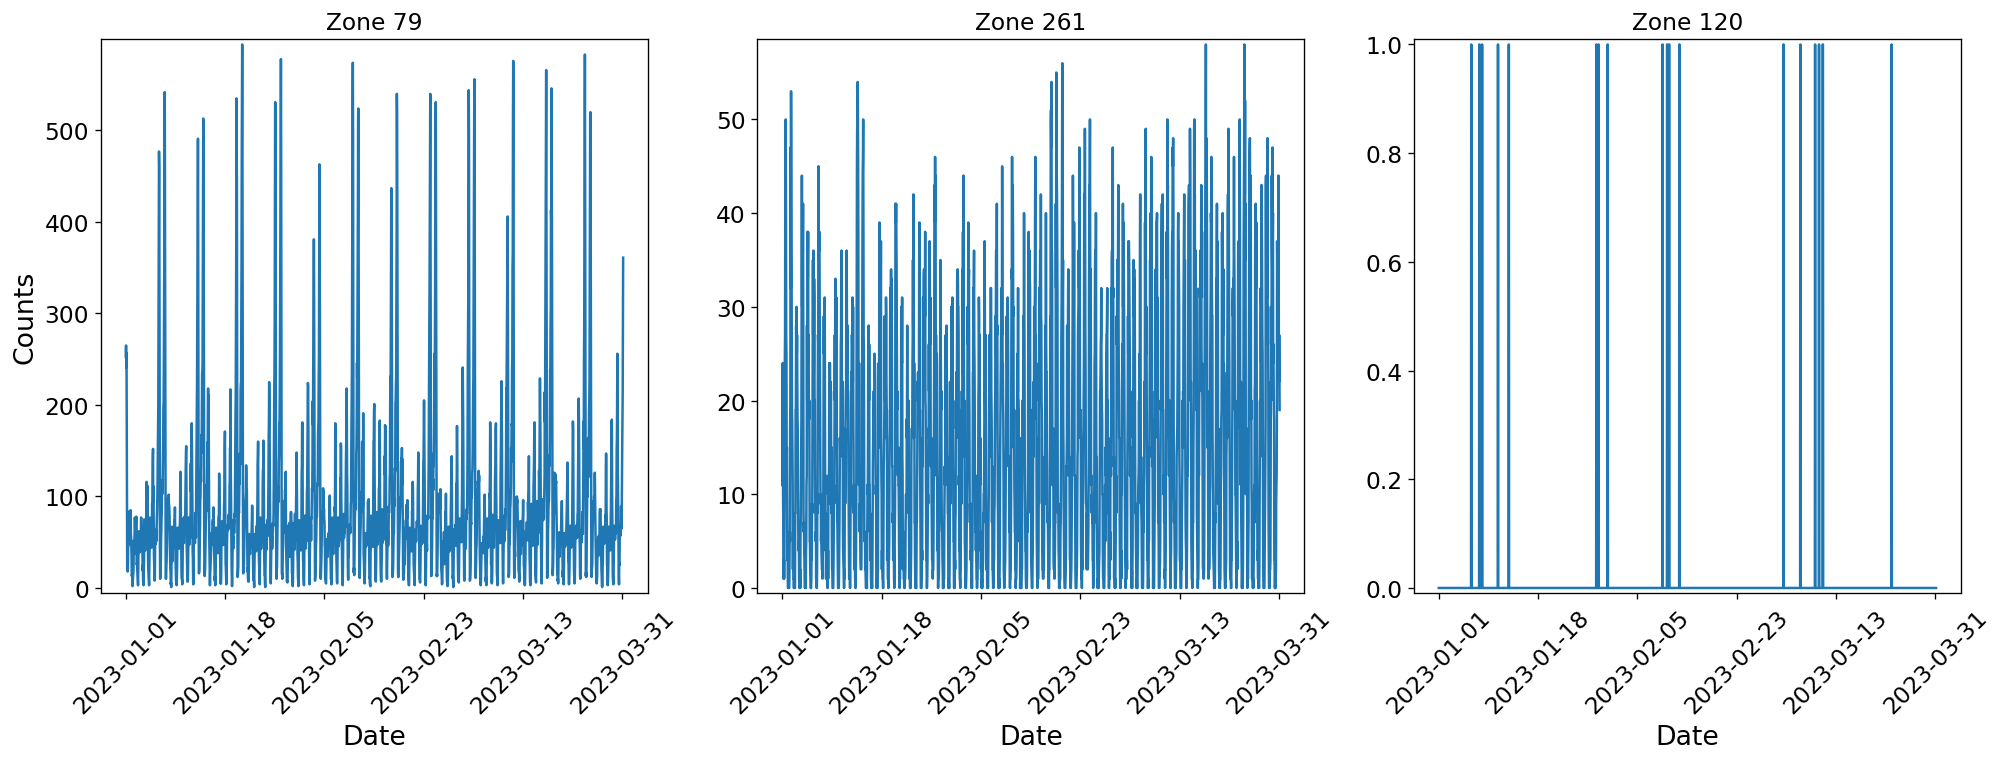

In [43]:
import matplotlib 
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# time series data for three other zones
fig, axes = plt.subplots(figsize = (20, 6), dpi = 120, nrows = 1, ncols = 3)
for i, z in enumerate([79, 261, 120]):
    ts_z = ts_p[ts_p['PULocationID'] == z].copy() # equivalent for route-level data: ts_z = pr.route_to_pulocation(ts, 4)
    # ts_z.plot(x = 'pickup_datetime', y = 'counts', ax = axes[i], fontsize = 16, title = f'Zone {z}')
    axes[i].plot(ts_z['pickup_datetime'], ts_z['counts'])
    axes[i].set_xlabel('Date', fontsize = 16)
    axes[i].set_xticks(ts_z['pickup_datetime'][::int(len(ts_z)/5)])
    axes[i].set_xticklabels(ts_z['pickup_datetime'].dt.date[::int(len(ts_z)/5)], rotation = 45, fontsize = 14)
    axes[i].set_title(f'Zone {z}', fontsize = 14)
    axes[i].set_ylim([-ts_z.counts.max() / 100, ts_z.counts.max() * (1 + 1/100)])
axes[0].set_ylabel('Counts', fontsize = 16)

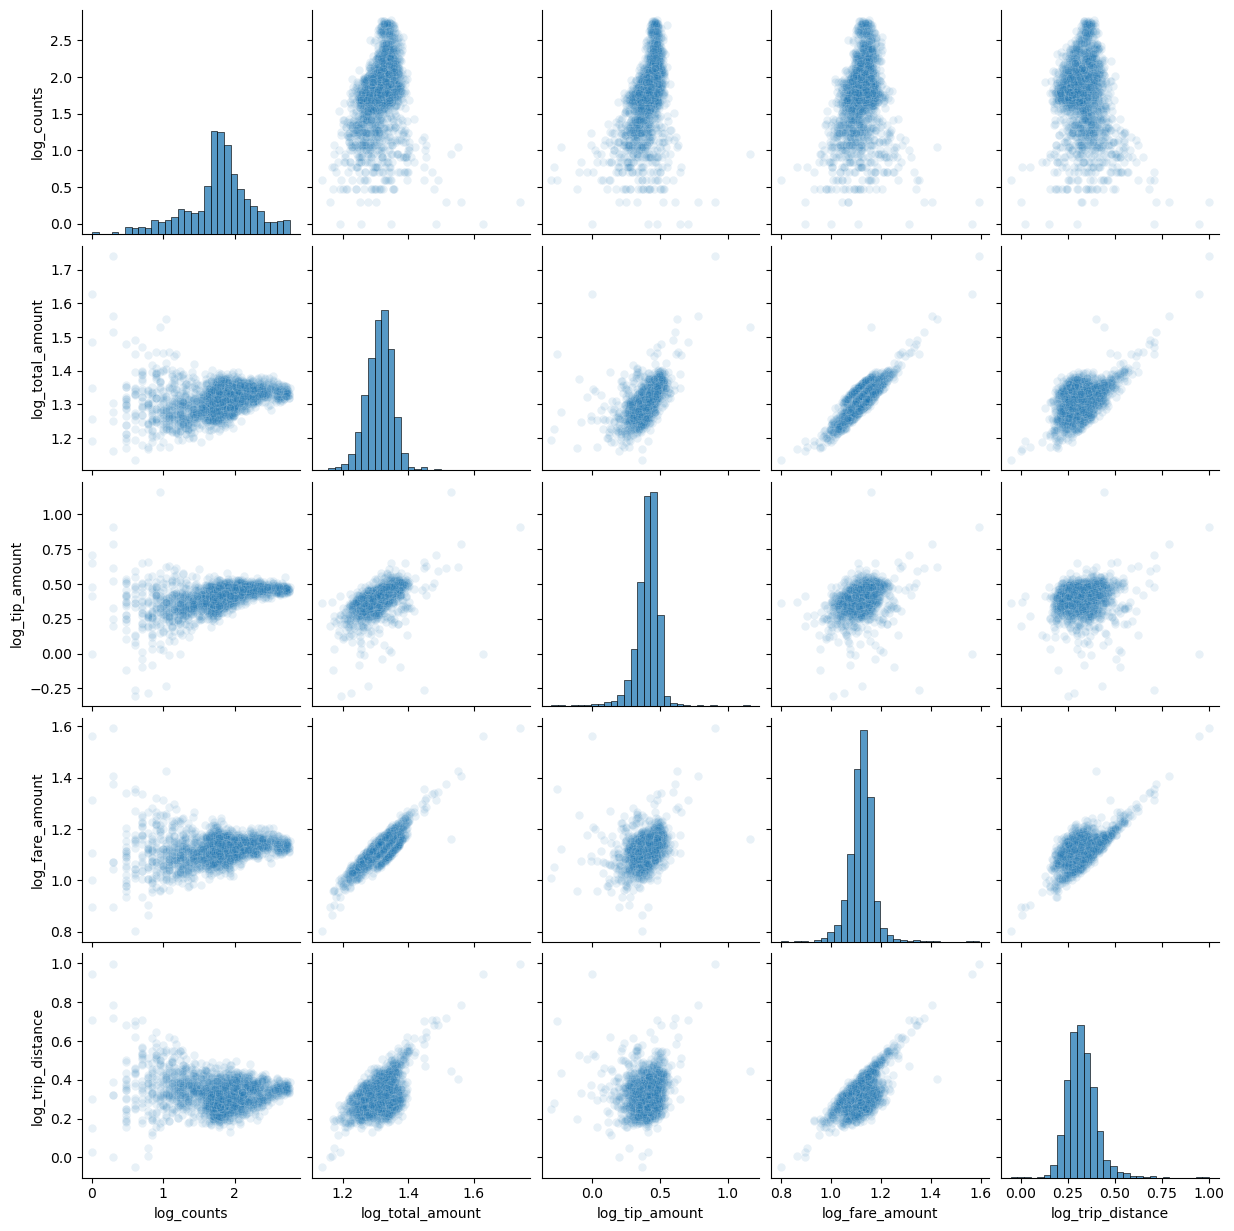

In [26]:
# time series data for zone 79 
features = ['counts', 'total_amount', 'tip_amount', 'fare_amount', 'trip_distance']
for f in features:
    ts_z['log_' + f] = np.log10(ts_z[f].values)
log_features = ['log_' + f for f in features]
sns.pairplot(ts_z[log_features], diag_kws = {'bins': 30}, plot_kws = {'alpha': 0.1})

/tmp/ipykernel_624/3444229871.py:4: RuntimeWarning: divide by zero encountered in log10
  ts_p['log_' + f] = np.log10(ts_p[f].values)


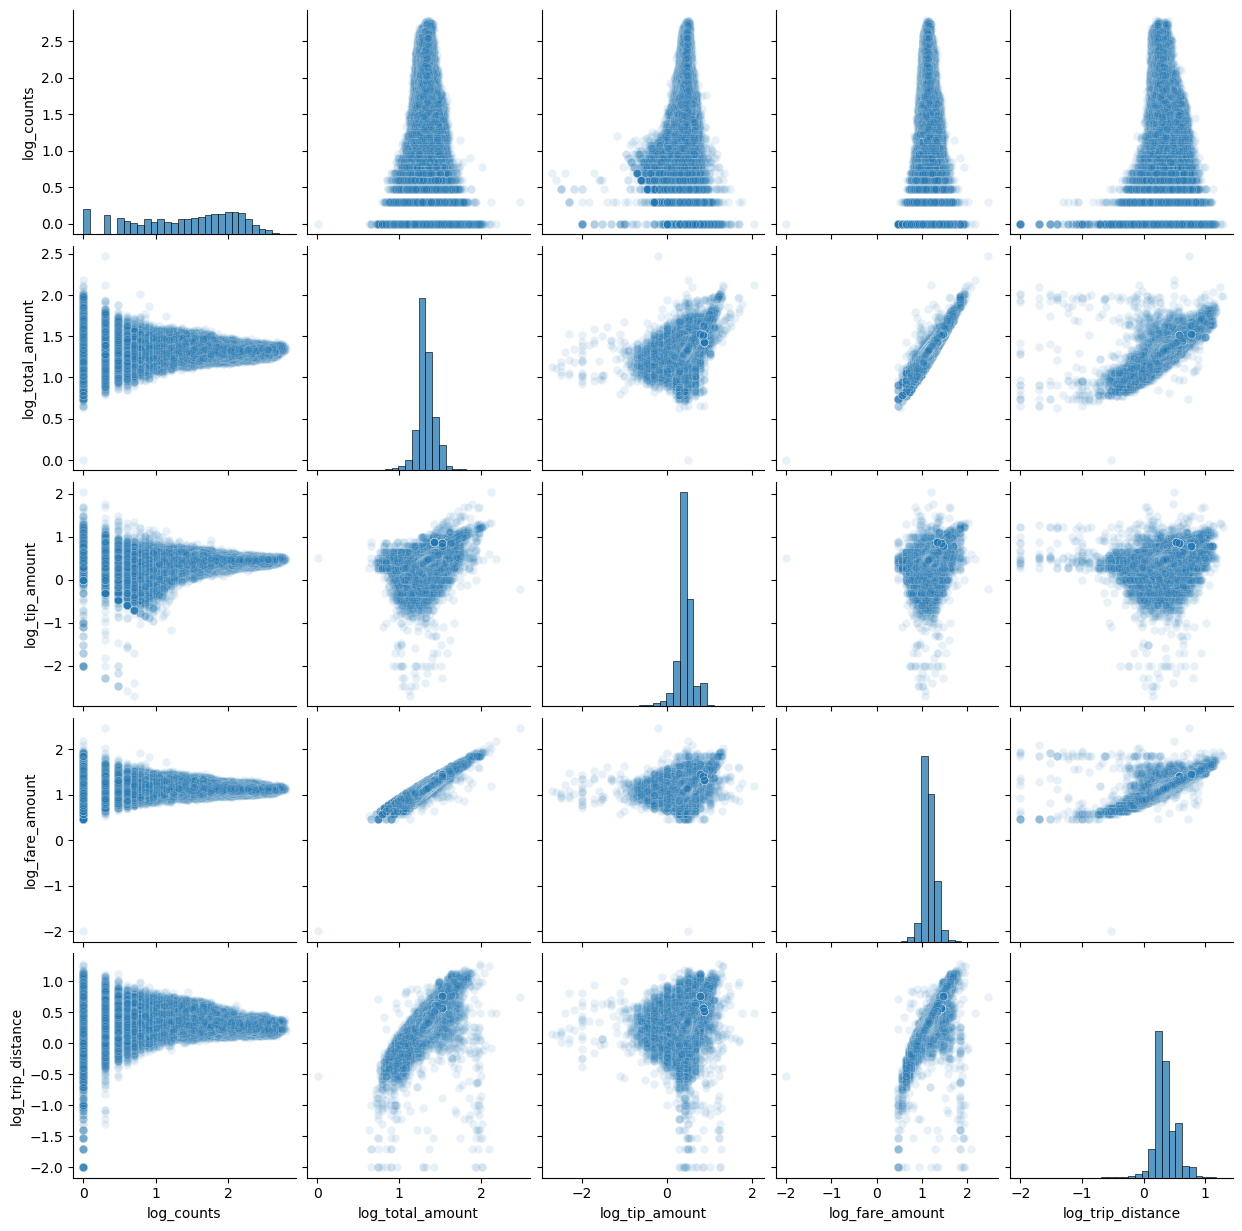

In [27]:
# time series data for all zones
features = ['counts', 'total_amount', 'tip_amount', 'fare_amount', 'trip_distance']
for f in features:
    ts_p['log_' + f] = np.log10(ts_p[f].values)
log_features = ['log_' + f for f in features]
sns.pairplot(ts_p[log_features], diag_kws = {'bins': 30}, plot_kws = {'alpha': 0.1})